In [1]:
import pandas as pd
import pyspark.sql.functions as F
from datetime import datetime
from pyspark.sql.types import *
from pyspark import StorageLevel

import numpy as np
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.set_option("mode.chained_assignment", None)

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

In [3]:
# !pip install scikit-plot

In [4]:
import sklearn 
import scikitplot as skplt
from sklearn.metrics import classification_report, confusion_matrix, precision_score

<hr />
<hr />
<hr />

In [5]:
addr_parquet = 'gs://ai-covid19-datalake/trusted/XGB-StratifiedSampleDatasets-3/dataset_3_positivepcrforcovid_000.parquet'

In [6]:
df = spark.read.parquet(addr_parquet)

In [7]:
id_cols = ['NU_NOTIFIC', 'CLASSI_FIN']

In [8]:
# taking out results of laboratorial exams (keeping only diagnostic images), dates, ids or integer attributes
cols = [
        'NU_NOTIFIC', 'CLASSI_FIN', 'CRITERIO', 'EVOLUCAO', 
        'AGE_GROUP', 'DIST_PRI_NOTIFIC_Q',
        'DIST_PRI_INTERNA_Q', 'DIST_PRI_ENTUTI_Q', 'DIST_PRI_SAIDUTI_Q', 'DIST_PRI_EVOLUCA_Q', 'DIST_PRI_ENCERRA_Q',
        'SYMP_GROUP1', 'SYMP_GROUP2', 'SYMP_GROUP3', 'SYMP_GROUP4',
        'RF_GROUP1', 'RF_GROUP2', 'RF_GROUP3', 'RF_GROUP4', 
        'SUPORT_VEN', 'UTI', 'HOSPITAL',
        'DIST_PRI_RAIOX_Q', 'DIST_PRI_TOMO_Q', 'DIST_PRI_IF_Q', 'DIST_PRI_TRA_Q', 'DIST_PRI_PCR_Q', 'DIST_PRI_SOR_Q',
        'RAIOX_RES', 'TOMO_RES', 
        'GMR_TRANSIT_STATIONS_1WEEK_BEFORE_Q', 'GMR_RETAIL_AND_RECREATION_1WEEK_BEFORE_Q', 'GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_Q', 'GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_Q',
        'GMR_TRANSIT_STATIONS_2WEEKS_Q', 'GMR_RETAIL_AND_RECREATION_2WEEKS_Q', 'GMR_RESIDENTIAL_PERCENT_2WEEKS_Q', 'GMR_WORKPLACES_PERCENT_2WEEKS_Q',
        'INMET_RELATIVE_AIR_HUMIDITY_1WEEK_BEFORE_Q', 'INMET_RELATIVE_AIR_HUMIDITY_2WEEKS_BEFORE_Q'
       ]

In [9]:
df.select(cols).limit(5).toPandas()

,NU_NOTIFIC,CLASSI_FIN,CRITERIO,EVOLUCAO,AGE_GROUP,DIST_PRI_NOTIFIC_Q,DIST_PRI_INTERNA_Q,DIST_PRI_ENTUTI_Q,DIST_PRI_SAIDUTI_Q,DIST_PRI_EVOLUCA_Q,DIST_PRI_ENCERRA_Q,SYMP_GROUP1,SYMP_GROUP2,SYMP_GROUP3,SYMP_GROUP4,RF_GROUP1,RF_GROUP2,RF_GROUP3,RF_GROUP4,SUPORT_VEN,UTI,HOSPITAL,DIST_PRI_RAIOX_Q,DIST_PRI_TOMO_Q,DIST_PRI_IF_Q,DIST_PRI_TRA_Q,DIST_PRI_PCR_Q,DIST_PRI_SOR_Q,RAIOX_RES,TOMO_RES,GMR_TRANSIT_STATIONS_1WEEK_BEFORE_Q,GMR_RETAIL_AND_RECREATION_1WEEK_BEFORE_Q,GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_Q,GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_Q,GMR_TRANSIT_STATIONS_2WEEKS_Q,GMR_RETAIL_AND_RECREATION_2WEEKS_Q,GMR_RESIDENTIAL_PERCENT_2WEEKS_Q,GMR_WORKPLACES_PERCENT_2WEEKS_Q,INMET_RELATIVE_AIR_HUMIDITY_1WEEK_BEFORE_Q,INMET_RELATIVE_AIR_HUMIDITY_2WEEKS_BEFORE_Q
0,68719825290,5,1,None,11,3,1,6,6,6,1,2,5,1,1,9,9,9,9,2,2,1,1,1,6,6,1,6,5.0,1,4,4,2,5,3,3,3,3,4,4
1,85899620235,5,1,None,10,3,2,6,6,6,1,1,1,1,1,9,9,9,9,3,2,1,6,1,6,6,1,6,6.0,1,4,4,2,5,3,3,3,3,4,4
2,68719771306,5,1,None,5,4,3,6,6,6,1,4,1,5,2,9,9,9,9,3,2,1,6,1,6,6,1,6,NaN,5,4,4,2,5,3,3,3,3,4,4
3,68719903358,5,1,None,5,1,1,1,6,6,1,1,2,3,5,9,9,9,9,3,1,1,6,1,6,6,1,6,9.0,2,4,4,2,5,3,3,3,3,4,4
4,68719749285,5,1,None,5,3,2,6,6,6,1,4,6,1,1,1,1,1,1,2,2,1,6,6,6,3,2,6,NaN,None,4,4,2,5,3,3,3,3,4,4


In [10]:
# 
num_cols = [x for x in cols if x not in id_cols] + ['CLASSI_FIN']

df = df.select(num_cols)
df = df.na.fill('9999')
df = df.na.fill(9999)
for col in num_cols:
    df = df.withColumn(col, F.col(col).cast('float'))

df = df.dropna()

In [11]:
# making some inspection of nulls
for col in df.select(num_cols).columns:
    print('{}: {}'.format(col, df.filter(F.col(col).isNull()).count()))

CRITERIO: 0
EVOLUCAO: 0
AGE_GROUP: 0
DIST_PRI_NOTIFIC_Q: 0
DIST_PRI_INTERNA_Q: 0
DIST_PRI_ENTUTI_Q: 0
DIST_PRI_SAIDUTI_Q: 0
DIST_PRI_EVOLUCA_Q: 0
DIST_PRI_ENCERRA_Q: 0
SYMP_GROUP1: 0
SYMP_GROUP2: 0
SYMP_GROUP3: 0
SYMP_GROUP4: 0
RF_GROUP1: 0
RF_GROUP2: 0
RF_GROUP3: 0
RF_GROUP4: 0
SUPORT_VEN: 0
UTI: 0
HOSPITAL: 0
DIST_PRI_RAIOX_Q: 0
DIST_PRI_TOMO_Q: 0
DIST_PRI_IF_Q: 0
DIST_PRI_TRA_Q: 0
DIST_PRI_PCR_Q: 0
DIST_PRI_SOR_Q: 0
RAIOX_RES: 0
TOMO_RES: 0
GMR_TRANSIT_STATIONS_1WEEK_BEFORE_Q: 0
GMR_RETAIL_AND_RECREATION_1WEEK_BEFORE_Q: 0
GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_Q: 0
GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_Q: 0
GMR_TRANSIT_STATIONS_2WEEKS_Q: 0
GMR_RETAIL_AND_RECREATION_2WEEKS_Q: 0
GMR_RESIDENTIAL_PERCENT_2WEEKS_Q: 0
GMR_WORKPLACES_PERCENT_2WEEKS_Q: 0
INMET_RELATIVE_AIR_HUMIDITY_1WEEK_BEFORE_Q: 0
INMET_RELATIVE_AIR_HUMIDITY_2WEEKS_BEFORE_Q: 0
CLASSI_FIN: 0


In [12]:
df = df.withColumn('CLASSI_FIN', F.when(F.col('CLASSI_FIN') == 1.0, 0.0).otherwise(1.0))

In [13]:
df.select('CLASSI_FIN').groupBy('CLASSI_FIN').count().orderBy('CLASSI_FIN').show()

# before codification of classi_fin 
# +----------+-----+
# |CLASSI_FIN|count|
# +----------+-----+
# |       1.0|28422|
# |       5.0|43478|
# +----------+-----+

+----------+-----+
|CLASSI_FIN|count|
+----------+-----+
|       0.0|28422|
|       1.0|43855|
+----------+-----+



In [14]:
df.select(num_cols).limit(1).toPandas()

,CRITERIO,EVOLUCAO,AGE_GROUP,DIST_PRI_NOTIFIC_Q,DIST_PRI_INTERNA_Q,DIST_PRI_ENTUTI_Q,DIST_PRI_SAIDUTI_Q,DIST_PRI_EVOLUCA_Q,DIST_PRI_ENCERRA_Q,SYMP_GROUP1,SYMP_GROUP2,SYMP_GROUP3,SYMP_GROUP4,RF_GROUP1,RF_GROUP2,RF_GROUP3,RF_GROUP4,SUPORT_VEN,UTI,HOSPITAL,DIST_PRI_RAIOX_Q,DIST_PRI_TOMO_Q,DIST_PRI_IF_Q,DIST_PRI_TRA_Q,DIST_PRI_PCR_Q,DIST_PRI_SOR_Q,RAIOX_RES,TOMO_RES,GMR_TRANSIT_STATIONS_1WEEK_BEFORE_Q,GMR_RETAIL_AND_RECREATION_1WEEK_BEFORE_Q,GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_Q,GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_Q,GMR_TRANSIT_STATIONS_2WEEKS_Q,GMR_RETAIL_AND_RECREATION_2WEEKS_Q,GMR_RESIDENTIAL_PERCENT_2WEEKS_Q,GMR_WORKPLACES_PERCENT_2WEEKS_Q,INMET_RELATIVE_AIR_HUMIDITY_1WEEK_BEFORE_Q,INMET_RELATIVE_AIR_HUMIDITY_2WEEKS_BEFORE_Q,CLASSI_FIN
0,1.0,9999.0,11.0,3.0,1.0,6.0,6.0,6.0,1.0,2.0,5.0,1.0,1.0,9.0,9.0,9.0,9.0,2.0,2.0,1.0,1.0,1.0,6.0,6.0,1.0,6.0,5.0,1.0,4.0,4.0,2.0,5.0,3.0,3.0,3.0,3.0,4.0,4.0,1.0


In [15]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="CLASSI_FIN", outputCol="indexedLabel").fit(df)

In [16]:
input_cols = [x for x in cols if x not in id_cols]
assembler = VectorAssembler(inputCols = input_cols, outputCol= 'features')
df = assembler.transform(df)

In [17]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=20).fit(df)

In [18]:
from pyspark import StorageLevel

In [19]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = df.randomSplit([0.7, 0.3])
trainingData = trainingData.persist(StorageLevel.MEMORY_ONLY)
testData = testData.persist(StorageLevel.MEMORY_ONLY)

In [20]:
# Train a RandomForest model.
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=50, maxDepth=10)

In [21]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [22]:
# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt, labelConverter])

In [23]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [24]:
# Make predictions.
predictions = model.transform(testData)

In [25]:
predictions.limit(1).toPandas()

,CRITERIO,EVOLUCAO,AGE_GROUP,DIST_PRI_NOTIFIC_Q,DIST_PRI_INTERNA_Q,DIST_PRI_ENTUTI_Q,DIST_PRI_SAIDUTI_Q,DIST_PRI_EVOLUCA_Q,DIST_PRI_ENCERRA_Q,SYMP_GROUP1,SYMP_GROUP2,SYMP_GROUP3,SYMP_GROUP4,RF_GROUP1,RF_GROUP2,RF_GROUP3,RF_GROUP4,SUPORT_VEN,UTI,HOSPITAL,DIST_PRI_RAIOX_Q,DIST_PRI_TOMO_Q,DIST_PRI_IF_Q,DIST_PRI_TRA_Q,DIST_PRI_PCR_Q,DIST_PRI_SOR_Q,RAIOX_RES,TOMO_RES,GMR_TRANSIT_STATIONS_1WEEK_BEFORE_Q,GMR_RETAIL_AND_RECREATION_1WEEK_BEFORE_Q,GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_Q,GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_Q,GMR_TRANSIT_STATIONS_2WEEKS_Q,GMR_RETAIL_AND_RECREATION_2WEEKS_Q,GMR_RESIDENTIAL_PERCENT_2WEEKS_Q,GMR_WORKPLACES_PERCENT_2WEEKS_Q,INMET_RELATIVE_AIR_HUMIDITY_1WEEK_BEFORE_Q,INMET_RELATIVE_AIR_HUMIDITY_2WEEKS_BEFORE_Q,CLASSI_FIN,features,indexedLabel,indexedFeatures,rawPrediction,probability,prediction,predictedLabel
0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9999.0,1.0,1.0,6.0,6.0,6.0,6.0,2.0,6.0,9999.0,9999.0,5.0,5.0,1.0,5.0,6.0,6.0,6.0,6.0,4.0,6.0,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, ...",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...","[-1.7175216758095742, 1.7175216758095742]","[0.031218042619825807, 0.9687819573801741]",1.0,0.0


In [26]:
# Select example rows to display.
predictions.select("predictedLabel", "indexedLabel", "indexedFeatures").show(50)

+--------------+------------+--------------------+
|predictedLabel|indexedLabel|     indexedFeatures|
+--------------+------------+--------------------+
|           0.0|         0.0|[0.0,0.0,0.0,0.0,...|
|           1.0|         0.0|[0.0,0.0,0.0,0.0,...|
|           1.0|         0.0|[0.0,0.0,0.0,0.0,...|
|           1.0|         0.0|[0.0,0.0,0.0,0.0,...|
|           0.0|         0.0|[0.0,0.0,0.0,0.0,...|
|           0.0|         0.0|[0.0,0.0,0.0,0.0,...|
|           0.0|         0.0|[0.0,0.0,0.0,0.0,...|
|           0.0|         0.0|[0.0,0.0,0.0,0.0,...|
|           0.0|         0.0|[0.0,0.0,0.0,0.0,...|
|           0.0|         0.0|[0.0,0.0,0.0,0.0,...|
|           0.0|         0.0|[0.0,0.0,0.0,0.0,...|
|           0.0|         0.0|[0.0,0.0,0.0,0.0,...|
|           0.0|         0.0|[0.0,0.0,0.0,1.0,...|
|           0.0|         0.0|[0.0,0.0,0.0,1.0,...|
|           0.0|         0.0|[0.0,0.0,0.0,1.0,...|
|           0.0|         0.0|[0.0,0.0,0.0,1.0,...|
|           0.0|         0.0|[0

In [27]:
# Select (prediction, true label) and compute test error
print('Area under ROC and Precision-Recall curves')
print('')
evaluator = BinaryClassificationEvaluator(
    labelCol="indexedLabel", rawPredictionCol="prediction", metricName="areaUnderROC")
accuracy = evaluator.evaluate(predictions)

print("Area Under ROC: {}".format(accuracy))



# Select (prediction, true label) and compute test error
evaluator = BinaryClassificationEvaluator(
    labelCol="indexedLabel", rawPredictionCol="prediction", metricName="areaUnderPR")
accuracy = evaluator.evaluate(predictions)

print("Area Under PR: {}".format(accuracy))

print('')
print('Classification Report')
print('')
# ------ #
pred = predictions.select(['CLASSI_FIN', 'predictedLabel'])\
                  .withColumn('predictedLabel', F.col('predictedLabel').cast('double'))\
                  .withColumn('predictedLabel', F.when(F.col('predictedLabel') == 1.0, 'covid').otherwise('n-covid'))\
                  .withColumn('CLASSI_FIN', F.when(F.col('CLASSI_FIN') == 1.0, 'covid').otherwise('n-covid'))\
                  .toPandas()

y_true = pred['CLASSI_FIN'].tolist()
y_pred = pred['predictedLabel'].tolist()

print(classification_report(y_true, y_pred))

print('')
print('Confusion Matrix')
print('')
confusion_matrix(y_true, y_pred)

Area under ROC and Precision-Recall curves

Area Under ROC: 0.952765848669661
Area Under PR: 0.9386759062946906

Classification Report

              precision    recall  f1-score   support

       covid       0.96      0.97      0.96     13119
     n-covid       0.96      0.93      0.94      8536

    accuracy                           0.96     21655
   macro avg       0.96      0.95      0.95     21655
weighted avg       0.96      0.96      0.96     21655


Confusion Matrix



array([[12768,   351],
       [  578,  7958]])

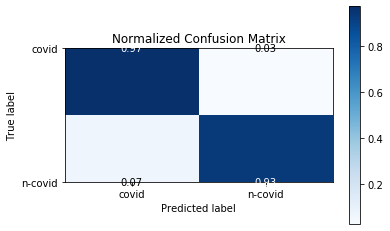

In [28]:
skplt.metrics.plot_confusion_matrix(y_true, y_pred, normalize='all')

In [29]:
rfModel = model.stages[2]
print(rfModel)  # summary only

GBTClassificationModel (uid=GBTClassifier_91b75c39d4f0) with 50 trees


In [30]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [31]:
ExtractFeatureImp(model.stages[-2].featureImportances, df, "features").head(100)

,idx,name,score
2,2,AGE_GROUP,0.315570
12,12,SYMP_GROUP4,0.092154
28,28,GMR_TRANSIT_STATIONS_1WEEK_BEFORE_Q,0.043106
24,24,DIST_PRI_PCR_Q,0.042059
30,30,GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_Q,0.030227
27,27,TOMO_RES,0.028335
26,26,RAIOX_RES,0.026223
9,9,SYMP_GROUP1,0.025648
31,31,GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_Q,0.025293
10,10,SYMP_GROUP2,0.024658


<hr />
<hr />
<hr />

### grid search

In [32]:
# pipeline = Pipeline(stages=[rf])

In [33]:
# paramGrid = ParamGridBuilder()\
#                             .addGrid(rf.seed, [2021]) \
#                             .addGrid(rf.numTrees, [21, 31]).build()

In [34]:
# paramGrid = ParamGridBuilder()\
#                             .addGrid(rf.seed, [2021]) \
#                             .addGrid(rf.numTrees, [21, 31]) \
#                             .addGrid(rf.maxDepth, [2, 5]) \
#                             .addGrid(rf.maxBins, [10, 30]) \
#                             .addGrid(rf.minInstancesPerNode, [1, 15]) \
#                             .addGrid(rf.minInfoGain, [0, 3]) \
#                             .addGrid(rf.featureSubsetStrategy, ['all', 'auto']) \
#                             .addGrid(rf.impurity, ['gini', 'entropy']).build()

In [35]:
# paramGrid = ParamGridBuilder()\
#                             .addGrid(rf.seed, [2021]) \
#                             .addGrid(rf.numTrees, range(10, 150, 30)) \
#                             .addGrid(rf.maxDepth, range(3, 15, 2)) \
#                             .addGrid(rf.maxBins, range(10, 90, 30)) \
#                             .addGrid(rf.minInstancesPerNode, range(1, 100, 20)) \
#                             .addGrid(rf.minInfoGain, range(0, 10, 2)) \
#                             .addGrid(rf.featureSubsetStrategy, ['all', 'auto', 'onethird', 'sqrt', 'log2']) \
#                             .addGrid(rf.impurity, ['gini', 'entropy']).build()

In [36]:
# crossval = CrossValidator(estimator=pipeline,
#                           estimatorParamMaps=paramGrid,
#                           evaluator=BinaryClassificationEvaluator(),
#                           numFolds=10) 

# cvModel = crossval.fit(trainingData)

In [37]:
# cvModel.bestModel.extractParamMap()

In [38]:
print('finished')

finished


<hr />
<hr />
<hr />

In [39]:
reclas_ss = spark.read.parquet('gs://ai-covid19-datalake/standard/underdiagnose_srag/base_reclass.parquet').persist(StorageLevel.MEMORY_ONLY)

#temp: this reclass dataset has no 8.0 category, and the fited data has
reclas_ss = reclas_ss.filter(F.col('RF_GROUP1') != 8.0)

In [40]:
reclas_ss.limit(2).toPandas()

,NU_NOTIFIC,CS_SEXO,DT_NASC,AGE_AT_NOTIF,AGE_GROUP,CS_GESTANT,CS_RACA,CS_ETINIA,CS_ESCOL_N,SG_UF,CO_MUN_RES,SEM_PRI,SEM_NOT,DIST_PRI_NOTIFIC,DT_SIN_PRI,SG_UF_NOT,CO_MUN_NOT,SURTO_SG,NOSOCOMIAL,AVE_SUINO,VACINA,HOSPITAL,DIST_PRI_INTERNA,SUPORT_VEN,UTI,DIST_PRI_ENTUTI,CLASSI_OUT,CRITERIO,EVOLUCAO,CLASSI_FIN,SYMP_GROUP1,SYMP_GROUP2,SYMP_GROUP3,SYMP_GROUP4,OUTRO_SIN,OUTRO_DES,RF_GROUP1,RF_GROUP2,RF_GROUP3,RF_GROUP4,OBES_IMC,OUT_MORBI,MORB_DESC,RAIOX_RES,DIST_PRI_RAIOX,TOMO_RES,DIST_PRI_TOMO,AMOSTRA,TP_AMOSTRA,DT_COLETA,DIST_PRI_COLETA,PP_IF_RESUL,PP_TRA_RESUL,DIST_PRI_TRA,PP_PCR_RESUL,DIST_PRI_PCR,PP_RES_SOR_IGA,PP_RES_SOR_IGM,PP_RES_SOR_IGG,DIST_PRI_SOR,DIST_PRI_IF,DIST_PRI_NOTIFIC_Q,DIST_PRI_INTERNA_Q,DIST_PRI_ENTUTI_Q,DIST_PRI_SAIDUTI_Q,DIST_PRI_EVOLUCA_Q,DIST_PRI_ENCERRA_Q,DIST_PRI_RAIOX_Q,DIST_PRI_TOMO_Q,DIST_PRI_COLETA_Q,DIST_PRI_SOR_Q,DIST_PRI_PCR_Q,DIST_PRI_TRA_Q,DIST_PRI_IF_Q,EPI_WEEK_YEAR,GMR_TRANSIT_STATIONS_AVG,GMR_GROCERY_AND_PHARMACY_AVG,GMR_RETAIL_AND_RECREATION_AVG,GMR_WORKPLACES_PERCENT_AVG,GMR_RESIDENTIAL_PERCENT_AVG,GMR_PARKS_PERCENT_AVG,GMR_TRANSIT_STATIONS_1WEEK_BEFORE_AVG,GMR_GROCERY_AND_PHARMACY_1WEEK_BEFORE_AVG,GMR_RETAIL_AND_RECREATION_1WEEK_BEFORE_AVG,GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_AVG,GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_AVG,GMR_PARKS_PERCENT_1WEEK_BEFORE_AVG,GMR_TRANSIT_STATIONS_2WEEKS_AVG,GMR_GROCERY_AND_PHARMACY_2WEEKS_AVG,GMR_RETAIL_AND_RECREATION_2WEEKS_AVG,GMR_WORKPLACES_PERCENT_2WEEKS_AVG,GMR_RESIDENTIAL_PERCENT_2WEEKS_AVG,GMR_PARKS_PERCENT_2WEEKS_AVG,INMET_TEMP_C_AVG,INMET_RELATIVE_AIR_HUMIDITY_AVG,INMET_DAILY_PRECIPT_AVG,INMET_TEMP_C_1WEEK_BEFORE_AVG,INMET_RELATIVE_AIR_HUMIDITY_1WEEK_BEFORE_AVG,INMET_DAILY_PRECIPT_1WEEK_BEFORE_AVG,INMET_TEMP_C_2WEEKS_BEFORE_AVG,INMET_RELATIVE_AIR_HUMIDITY_2WEEKS_BEFORE_AVG,INMET_DAILY_PRECIPT_2WEEKS_BEFORE_AVG,GMR_TRANSIT_STATIONS_Q,GMR_GROCERY_AND_PHARMACY_Q,GMR_RETAIL_AND_RECREATION_Q,GMR_WORKPLACES_PERCENT_Q,GMR_RESIDENTIAL_PERCENT_Q,GMR_PARKS_PERCENT_Q,GMR_TRANSIT_STATIONS_1WEEK_BEFORE_Q,GMR_GROCERY_AND_PHARMACY_1WEEK_BEFORE_Q,GMR_RETAIL_AND_RECREATION_1WEEK_BEFORE_Q,GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_Q,GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_Q,GMR_PARKS_PERCENT_1WEEK_BEFORE_Q,GMR_TRANSIT_STATIONS_2WEEKS_Q,GMR_GROCERY_AND_PHARMACY_2WEEKS_Q,GMR_RETAIL_AND_RECREATION_2WEEKS_Q,GMR_WORKPLACES_PERCENT_2WEEKS_Q,GMR_RESIDENTIAL_PERCENT_2WEEKS_Q,GMR_PARKS_PERCENT_2WEEKS_Q,INMET_TEMP_C_Q,INMET_RELATIVE_AIR_HUMIDITY_Q,INMET_DAILY_PRECIPT_Q,INMET_TEMP_C_1WEEK_BEFORE_Q,INMET_RELATIVE_AIR_HUMIDITY_1WEEK_BEFORE_Q,INMET_DAILY_PRECIPT_1WEEK_BEFORE_Q,INMET_TEMP_C_2WEEKS_BEFORE_Q,INMET_RELATIVE_AIR_HUMIDITY_2WEEKS_BEFORE_Q,INMET_DAILY_PRECIPT_2WEEKS_BEFORE_Q,ANO
0,77309844813,F,1948-10-14,72,9,5,4,None,None,BA,293330,19,20,5,2021-05-13,BA,293330,None,2,9,None,1,4,2,2,None,None,None,2,4,1,5,1,1,1,DISURIA,1,1,1,1,None,None,None,None,None,3,4,2,None,None,None,9,9,None,6,None,4,4,4,None,None,2,2,6,6,1,1,6,2,6,6,6,6,6,19-2021,-26.208333333333332,31.78846153846154,-24.07913669064748,-0.09990485252140818,7.358333333333333,-44.62532981530343,-25.097435897435897,34.628571428571426,-20.930313588850176,0.7737642585551331,6.81767955801105,-44.47229551451187,-31.23316062176166,17.257009345794394,-30.477192982456142,-4.605238540692236,8.130555555555556,-46.52685421994885,22.265185118812038,71.29946775652336,1.1157894736841916,23.258355336538234,74.98425431932834,2.1599999999999855,24.09200810576895,74.7330944957982,1.6530120481927677,3,5,3,4,2,2,4,5,4,5,2,2,3,4,3,3,3,1,2,3,2,3,4,3,4,4,2,2021
1,85899754416,F,1953-11-19,67,8,5,9,None,None,BA,293330,19,20,6,2021-05-15,BA,293330,None,2,2,1,1,5,2,2,None,None,1,1,4,1,8,1,1,2,None,9,9,9,9,None,1,EPILEPSIA,6,None,None,None,1,1,2021-05-20,5,9,9,None,7,None,4,4,4,None,None,3,3,6,6,1,1,6,6,3,6,6,6,6,19-2021,-26.208333333333332,31.78846153846154,-24.07913669064748,-0.09990485252140818,7.358333333333333,-44.62532981530343,-25.097435897435897,34.628571428571426,-20.930313588850176,0.7737642585551331,6.81767955801105,-44.47229551451187,-31.23316062176

In [41]:
reclas_ss.select('CLASSI_FIN').groupBy('CLASSI_FIN').count().show()

+----------+------+
|CLASSI_FIN| count|
+----------+------+
|         4|571884|
+----------+------+



In [42]:
# 
num_cols = [x for x in cols if x not in id_cols] + ['CLASSI_FIN']

reclas_ss = reclas_ss.select(num_cols + ['NU_NOTIFIC'])
reclas_ss = reclas_ss.na.fill('9999')
reclas_ss = reclas_ss.na.fill(9999)
for col in num_cols:
    reclas_ss = reclas_ss.withColumn(col, F.col(col).cast('float'))

reclas_ss = reclas_ss.dropna()

In [43]:
# making some inspection of nulls
for col in df.select(num_cols).columns:
    print('{}: {}'.format(col, reclas_ss.filter(F.col(col).isNull()).count()))

CRITERIO: 0
EVOLUCAO: 0
AGE_GROUP: 0
DIST_PRI_NOTIFIC_Q: 0
DIST_PRI_INTERNA_Q: 0
DIST_PRI_ENTUTI_Q: 0
DIST_PRI_SAIDUTI_Q: 0
DIST_PRI_EVOLUCA_Q: 0
DIST_PRI_ENCERRA_Q: 0
SYMP_GROUP1: 0
SYMP_GROUP2: 0
SYMP_GROUP3: 0
SYMP_GROUP4: 0
RF_GROUP1: 0
RF_GROUP2: 0
RF_GROUP3: 0
RF_GROUP4: 0
SUPORT_VEN: 0
UTI: 0
HOSPITAL: 0
DIST_PRI_RAIOX_Q: 0
DIST_PRI_TOMO_Q: 0
DIST_PRI_IF_Q: 0
DIST_PRI_TRA_Q: 0
DIST_PRI_PCR_Q: 0
DIST_PRI_SOR_Q: 0
RAIOX_RES: 0
TOMO_RES: 0
GMR_TRANSIT_STATIONS_1WEEK_BEFORE_Q: 0
GMR_RETAIL_AND_RECREATION_1WEEK_BEFORE_Q: 0
GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_Q: 0
GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_Q: 0
GMR_TRANSIT_STATIONS_2WEEKS_Q: 0
GMR_RETAIL_AND_RECREATION_2WEEKS_Q: 0
GMR_RESIDENTIAL_PERCENT_2WEEKS_Q: 0
GMR_WORKPLACES_PERCENT_2WEEKS_Q: 0
INMET_RELATIVE_AIR_HUMIDITY_1WEEK_BEFORE_Q: 0
INMET_RELATIVE_AIR_HUMIDITY_2WEEKS_BEFORE_Q: 0
CLASSI_FIN: 0


In [44]:
# just transforming CLASSI_FIN's unclassified category for a valid one, it willnot be used on the classfic. task
reclas_ss = reclas_ss.withColumn('CLASSI_FIN', F.lit(0.0))
reclas_ss.select('CLASSI_FIN').groupBy('CLASSI_FIN').count().show()

+----------+------+
|CLASSI_FIN| count|
+----------+------+
|       0.0|571884|
+----------+------+



In [45]:
reclas_ss.printSchema()

root
 |-- CRITERIO: float (nullable = true)
 |-- EVOLUCAO: float (nullable = true)
 |-- AGE_GROUP: float (nullable = true)
 |-- DIST_PRI_NOTIFIC_Q: float (nullable = true)
 |-- DIST_PRI_INTERNA_Q: float (nullable = true)
 |-- DIST_PRI_ENTUTI_Q: float (nullable = true)
 |-- DIST_PRI_SAIDUTI_Q: float (nullable = true)
 |-- DIST_PRI_EVOLUCA_Q: float (nullable = true)
 |-- DIST_PRI_ENCERRA_Q: float (nullable = true)
 |-- SYMP_GROUP1: float (nullable = true)
 |-- SYMP_GROUP2: float (nullable = true)
 |-- SYMP_GROUP3: float (nullable = true)
 |-- SYMP_GROUP4: float (nullable = true)
 |-- RF_GROUP1: float (nullable = true)
 |-- RF_GROUP2: float (nullable = true)
 |-- RF_GROUP3: float (nullable = true)
 |-- RF_GROUP4: float (nullable = true)
 |-- SUPORT_VEN: float (nullable = true)
 |-- UTI: float (nullable = true)
 |-- HOSPITAL: float (nullable = true)
 |-- DIST_PRI_RAIOX_Q: float (nullable = true)
 |-- DIST_PRI_TOMO_Q: float (nullable = true)
 |-- DIST_PRI_IF_Q: float (nullable = true)
 |-- 

In [46]:
input_cols = [x for x in cols if x not in id_cols]
assembler = VectorAssembler(inputCols = input_cols, outputCol= 'features') #handleInvalid='skip'
reclas_ss = assembler.transform(reclas_ss)

In [47]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=20).fit(reclas_ss.select(input_cols + ['features', 'NU_NOTIFIC'])) #handleInvalid='skip'

In [48]:
reclas_ss.limit(2).toPandas()

,CRITERIO,EVOLUCAO,AGE_GROUP,DIST_PRI_NOTIFIC_Q,DIST_PRI_INTERNA_Q,DIST_PRI_ENTUTI_Q,DIST_PRI_SAIDUTI_Q,DIST_PRI_EVOLUCA_Q,DIST_PRI_ENCERRA_Q,SYMP_GROUP1,SYMP_GROUP2,SYMP_GROUP3,SYMP_GROUP4,RF_GROUP1,RF_GROUP2,RF_GROUP3,RF_GROUP4,SUPORT_VEN,UTI,HOSPITAL,DIST_PRI_RAIOX_Q,DIST_PRI_TOMO_Q,DIST_PRI_IF_Q,DIST_PRI_TRA_Q,DIST_PRI_PCR_Q,DIST_PRI_SOR_Q,RAIOX_RES,TOMO_RES,GMR_TRANSIT_STATIONS_1WEEK_BEFORE_Q,GMR_RETAIL_AND_RECREATION_1WEEK_BEFORE_Q,GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_Q,GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_Q,GMR_TRANSIT_STATIONS_2WEEKS_Q,GMR_RETAIL_AND_RECREATION_2WEEKS_Q,GMR_RESIDENTIAL_PERCENT_2WEEKS_Q,GMR_WORKPLACES_PERCENT_2WEEKS_Q,INMET_RELATIVE_AIR_HUMIDITY_1WEEK_BEFORE_Q,INMET_RELATIVE_AIR_HUMIDITY_2WEEKS_BEFORE_Q,CLASSI_FIN,NU_NOTIFIC,features
0,9999.0,2.0,9.0,2.0,2.0,6.0,6.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,6.0,2.0,6.0,6.0,6.0,6.0,9999.0,3.0,4.0,4.0,2.0,5.0,3.0,3.0,3.0,3.0,4.0,4.0,0.0,77309844813,"[9999.0, 2.0, 9.0, 2.0, 2.0, 6.0, 6.0, 1.0, 1...."
1,1.0,1.0,8.0,3.0,3.0,6.0,6.0,1.0,1.0,1.0,8.0,1.0,1.0,9.0,9.0,9.0,9.0,2.0,2.0,1.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,9999.0,4.0,4.0,2.0,5.0,3.0,3.0,3.0,3.0,4.0,4.0,0.0,85899754416,"[1.0, 1.0, 8.0, 3.0, 3.0, 6.0, 6.0, 1.0, 1.0, ..."


In [49]:
reclas_ss_pred = model.transform(reclas_ss)

In [50]:
reclas_ss_pred.limit(2).toPandas()

,CRITERIO,EVOLUCAO,AGE_GROUP,DIST_PRI_NOTIFIC_Q,DIST_PRI_INTERNA_Q,DIST_PRI_ENTUTI_Q,DIST_PRI_SAIDUTI_Q,DIST_PRI_EVOLUCA_Q,DIST_PRI_ENCERRA_Q,SYMP_GROUP1,SYMP_GROUP2,SYMP_GROUP3,SYMP_GROUP4,RF_GROUP1,RF_GROUP2,RF_GROUP3,RF_GROUP4,SUPORT_VEN,UTI,HOSPITAL,DIST_PRI_RAIOX_Q,DIST_PRI_TOMO_Q,DIST_PRI_IF_Q,DIST_PRI_TRA_Q,DIST_PRI_PCR_Q,DIST_PRI_SOR_Q,RAIOX_RES,TOMO_RES,GMR_TRANSIT_STATIONS_1WEEK_BEFORE_Q,GMR_RETAIL_AND_RECREATION_1WEEK_BEFORE_Q,GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_Q,GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_Q,GMR_TRANSIT_STATIONS_2WEEKS_Q,GMR_RETAIL_AND_RECREATION_2WEEKS_Q,GMR_RESIDENTIAL_PERCENT_2WEEKS_Q,GMR_WORKPLACES_PERCENT_2WEEKS_Q,INMET_RELATIVE_AIR_HUMIDITY_1WEEK_BEFORE_Q,INMET_RELATIVE_AIR_HUMIDITY_2WEEKS_BEFORE_Q,CLASSI_FIN,NU_NOTIFIC,features,indexedLabel,indexedFeatures,rawPrediction,probability,prediction,predictedLabel
0,9999.0,2.0,9.0,2.0,2.0,6.0,6.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,6.0,2.0,6.0,6.0,6.0,6.0,9999.0,3.0,4.0,4.0,2.0,5.0,3.0,3.0,3.0,3.0,4.0,4.0,0.0,77309844813,"[9999.0, 2.0, 9.0, 2.0, 2.0, 6.0, 6.0, 1.0, 1....",1.0,"[4.0, 1.0, 8.0, 1.0, 1.0, 5.0, 5.0, 0.0, 0.0, ...","[-1.9085017924509402, 1.9085017924509402]","[0.02152029536662839, 0.9784797046333716]",1.0,0.0
1,1.0,1.0,8.0,3.0,3.0,6.0,6.0,1.0,1.0,1.0,8.0,1.0,1.0,9.0,9.0,9.0,9.0,2.0,2.0,1.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,9999.0,4.0,4.0,2.0,5.0,3.0,3.0,3.0,3.0,4.0,4.0,0.0,85899754416,"[1.0, 1.0, 8.0, 3.0, 3.0, 6.0, 6.0, 1.0, 1.0, ...",1.0,"[0.0, 0.0, 7.0, 2.0, 2.0, 5.0, 5.0, 0.0, 0.0, ...","[-1.9085017924509402, 1.9085017924509402]","[0.02152029536662839, 0.9784797046333716]",1.0,0.0


In [51]:
reclas_ss_pred.select('CLASSI_FIN').groupBy('CLASSI_FIN').count().show()

+----------+------+
|CLASSI_FIN| count|
+----------+------+
|       0.0|571884|
+----------+------+



In [52]:
reclas_ss_pred.select('predictedLabel').groupBy('predictedLabel').count().show()

+--------------+------+
|predictedLabel| count|
+--------------+------+
|           1.0|361003|
|           0.0|210881|
+--------------+------+



In [53]:
reclas_ss_pred.filter((F.col('predictedLabel') == 1.0)).groupBy('EVOLUCAO').count().orderBy('EVOLUCAO').show()

+--------+------+
|EVOLUCAO| count|
+--------+------+
|     1.0|232057|
|     2.0| 77473|
|     3.0| 11417|
|     9.0| 12017|
|  9999.0| 28039|
+--------+------+



<hr />
<hr />
<hr />

### result predicted dataset

In [54]:
struct_dataset = addr_parquet.split('_')
number_dataset = addr_parquet.split('_')[1]
name_dataset = addr_parquet.split('_')[2]
id_sample = addr_parquet.split('_')[-1].split('.')[0]

In [55]:
reclas_ss = spark.read.parquet('gs://ai-covid19-datalake/standard/underdiagnose_srag/base_reclass.parquet').persist(StorageLevel.MEMORY_ONLY)

In [56]:
reclas_ss.limit(2).toPandas()

,NU_NOTIFIC,CS_SEXO,DT_NASC,AGE_AT_NOTIF,AGE_GROUP,CS_GESTANT,CS_RACA,CS_ETINIA,CS_ESCOL_N,SG_UF,CO_MUN_RES,SEM_PRI,SEM_NOT,DIST_PRI_NOTIFIC,DT_SIN_PRI,SG_UF_NOT,CO_MUN_NOT,SURTO_SG,NOSOCOMIAL,AVE_SUINO,VACINA,HOSPITAL,DIST_PRI_INTERNA,SUPORT_VEN,UTI,DIST_PRI_ENTUTI,CLASSI_OUT,CRITERIO,EVOLUCAO,CLASSI_FIN,SYMP_GROUP1,SYMP_GROUP2,SYMP_GROUP3,SYMP_GROUP4,OUTRO_SIN,OUTRO_DES,RF_GROUP1,RF_GROUP2,RF_GROUP3,RF_GROUP4,OBES_IMC,OUT_MORBI,MORB_DESC,RAIOX_RES,DIST_PRI_RAIOX,TOMO_RES,DIST_PRI_TOMO,AMOSTRA,TP_AMOSTRA,DT_COLETA,DIST_PRI_COLETA,PP_IF_RESUL,PP_TRA_RESUL,DIST_PRI_TRA,PP_PCR_RESUL,DIST_PRI_PCR,PP_RES_SOR_IGA,PP_RES_SOR_IGM,PP_RES_SOR_IGG,DIST_PRI_SOR,DIST_PRI_IF,DIST_PRI_NOTIFIC_Q,DIST_PRI_INTERNA_Q,DIST_PRI_ENTUTI_Q,DIST_PRI_SAIDUTI_Q,DIST_PRI_EVOLUCA_Q,DIST_PRI_ENCERRA_Q,DIST_PRI_RAIOX_Q,DIST_PRI_TOMO_Q,DIST_PRI_COLETA_Q,DIST_PRI_SOR_Q,DIST_PRI_PCR_Q,DIST_PRI_TRA_Q,DIST_PRI_IF_Q,EPI_WEEK_YEAR,GMR_TRANSIT_STATIONS_AVG,GMR_GROCERY_AND_PHARMACY_AVG,GMR_RETAIL_AND_RECREATION_AVG,GMR_WORKPLACES_PERCENT_AVG,GMR_RESIDENTIAL_PERCENT_AVG,GMR_PARKS_PERCENT_AVG,GMR_TRANSIT_STATIONS_1WEEK_BEFORE_AVG,GMR_GROCERY_AND_PHARMACY_1WEEK_BEFORE_AVG,GMR_RETAIL_AND_RECREATION_1WEEK_BEFORE_AVG,GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_AVG,GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_AVG,GMR_PARKS_PERCENT_1WEEK_BEFORE_AVG,GMR_TRANSIT_STATIONS_2WEEKS_AVG,GMR_GROCERY_AND_PHARMACY_2WEEKS_AVG,GMR_RETAIL_AND_RECREATION_2WEEKS_AVG,GMR_WORKPLACES_PERCENT_2WEEKS_AVG,GMR_RESIDENTIAL_PERCENT_2WEEKS_AVG,GMR_PARKS_PERCENT_2WEEKS_AVG,INMET_TEMP_C_AVG,INMET_RELATIVE_AIR_HUMIDITY_AVG,INMET_DAILY_PRECIPT_AVG,INMET_TEMP_C_1WEEK_BEFORE_AVG,INMET_RELATIVE_AIR_HUMIDITY_1WEEK_BEFORE_AVG,INMET_DAILY_PRECIPT_1WEEK_BEFORE_AVG,INMET_TEMP_C_2WEEKS_BEFORE_AVG,INMET_RELATIVE_AIR_HUMIDITY_2WEEKS_BEFORE_AVG,INMET_DAILY_PRECIPT_2WEEKS_BEFORE_AVG,GMR_TRANSIT_STATIONS_Q,GMR_GROCERY_AND_PHARMACY_Q,GMR_RETAIL_AND_RECREATION_Q,GMR_WORKPLACES_PERCENT_Q,GMR_RESIDENTIAL_PERCENT_Q,GMR_PARKS_PERCENT_Q,GMR_TRANSIT_STATIONS_1WEEK_BEFORE_Q,GMR_GROCERY_AND_PHARMACY_1WEEK_BEFORE_Q,GMR_RETAIL_AND_RECREATION_1WEEK_BEFORE_Q,GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_Q,GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_Q,GMR_PARKS_PERCENT_1WEEK_BEFORE_Q,GMR_TRANSIT_STATIONS_2WEEKS_Q,GMR_GROCERY_AND_PHARMACY_2WEEKS_Q,GMR_RETAIL_AND_RECREATION_2WEEKS_Q,GMR_WORKPLACES_PERCENT_2WEEKS_Q,GMR_RESIDENTIAL_PERCENT_2WEEKS_Q,GMR_PARKS_PERCENT_2WEEKS_Q,INMET_TEMP_C_Q,INMET_RELATIVE_AIR_HUMIDITY_Q,INMET_DAILY_PRECIPT_Q,INMET_TEMP_C_1WEEK_BEFORE_Q,INMET_RELATIVE_AIR_HUMIDITY_1WEEK_BEFORE_Q,INMET_DAILY_PRECIPT_1WEEK_BEFORE_Q,INMET_TEMP_C_2WEEKS_BEFORE_Q,INMET_RELATIVE_AIR_HUMIDITY_2WEEKS_BEFORE_Q,INMET_DAILY_PRECIPT_2WEEKS_BEFORE_Q,ANO
0,77309844813,F,1948-10-14,72,9,5,4,None,None,BA,293330,19,20,5,2021-05-13,BA,293330,None,2,9,None,1,4,2,2,None,None,None,2,4,1,5,1,1,1,DISURIA,1,1,1,1,None,None,None,None,None,3,4,2,None,None,None,9,9,None,6,None,4,4,4,None,None,2,2,6,6,1,1,6,2,6,6,6,6,6,19-2021,-26.208333333333332,31.78846153846154,-24.07913669064748,-0.09990485252140818,7.358333333333333,-44.62532981530343,-25.097435897435897,34.628571428571426,-20.930313588850176,0.7737642585551331,6.81767955801105,-44.47229551451187,-31.23316062176166,17.257009345794394,-30.477192982456142,-4.605238540692236,8.130555555555556,-46.52685421994885,22.265185118812038,71.29946775652336,1.1157894736841916,23.258355336538234,74.98425431932834,2.1599999999999855,24.09200810576895,74.7330944957982,1.6530120481927677,3,5,3,4,2,2,4,5,4,5,2,2,3,4,3,3,3,1,2,3,2,3,4,3,4,4,2,2021
1,85899754416,F,1953-11-19,67,8,5,9,None,None,BA,293330,19,20,6,2021-05-15,BA,293330,None,2,2,1,1,5,2,2,None,None,1,1,4,1,8,1,1,2,None,9,9,9,9,None,1,EPILEPSIA,6,None,None,None,1,1,2021-05-20,5,9,9,None,7,None,4,4,4,None,None,3,3,6,6,1,1,6,6,3,6,6,6,6,19-2021,-26.208333333333332,31.78846153846154,-24.07913669064748,-0.09990485252140818,7.358333333333333,-44.62532981530343,-25.097435897435897,34.628571428571426,-20.930313588850176,0.7737642585551331,6.81767955801105,-44.47229551451187,-31.23316062176

In [57]:
reclas_ss_pred = reclas_ss_pred.select(['NU_NOTIFIC', 'predictedLabel']).withColumnRenamed('predictedLabel', 'CLASSI_FIN_pred_'+id_sample)

In [58]:
reclas_ss_pred.limit(2).toPandas()

,NU_NOTIFIC,CLASSI_FIN_pred_000
0,77309844813,0.0
1,85899754416,0.0


In [59]:
# to enable some validation after the join
c = reclas_ss.count()
dist_c = reclas_ss.distinct().count()
print('Reclass dataset has {} records, {} of them has a distinct NU_NOTIFIC.'.format(c, dist_c))

c = reclas_ss_pred.count()
dist_c = reclas_ss_pred.distinct().count()
print('Predicted Reclass dataset has {} records, {} of them has a distinct NU_NOTIFIC.'.format(c, dist_c))

Reclass dataset has 571910 records, 571910 of them has a distinct NU_NOTIFIC.
Predicted Reclass dataset has 571884 records, 571884 of them has a distinct NU_NOTIFIC.


In [60]:
reclas_ss = reclas_ss.join(reclas_ss_pred, 'NU_NOTIFIC', 'left')

In [61]:
# performing some validation
c = reclas_ss.count()
dist_c = reclas_ss.distinct().count()
print('Reclass dataset has {} records, {} of them has a distinct NU_NOTIFIC.'.format(c, dist_c))

Reclass dataset has 571910 records, 571910 of them has a distinct NU_NOTIFIC.


In [62]:
# writing result
reclas_ss.write.parquet('gs://ai-covid19-datalake/trusted/GBT-StratifiedSampleDatasets-3-RESULT.parquet', mode='overwrite')

In [63]:
reclas_ss.select('CLASSI_FIN_pred_000','ANO')\
         .filter((F.col('CLASSI_FIN_pred_000') == 1.0))\
         .groupBy('ANO').count()\
         .orderBy('ANO').show(100)

+----+------+
| ANO| count|
+----+------+
|2018|     5|
|2019|    57|
|2020|288843|
|2021| 72098|
+----+------+



In [64]:
reclas_ss.select('CLASSI_FIN_pred_000', 'AGE_GROUP', 'EVOLUCAO', 'ANO')\
         .filter((F.col('CLASSI_FIN_pred_000') == 1.0))\
         .groupBy('ANO', 'AGE_GROUP', 'EVOLUCAO').count()\
         .orderBy(['ANO', 'AGE_GROUP', 'EVOLUCAO']).show(200)

+----+---------+--------+-----+
| ANO|AGE_GROUP|EVOLUCAO|count|
+----+---------+--------+-----+
|2018|       10|       1|    1|
|2018|       10|       2|    1|
|2018|        5|    null|    1|
|2018|        5|       1|    2|
|2019|       10|    null|    2|
|2019|       10|       1|    2|
|2019|       10|       2|    3|
|2019|       10|       9|    1|
|2019|       11|       1|    1|
|2019|        4|       1|    8|
|2019|        4|       2|    1|
|2019|        5|    null|    2|
|2019|        5|       1|    7|
|2019|        5|       2|    2|
|2019|        6|    null|    1|
|2019|        7|       1|    9|
|2019|        7|       2|    4|
|2019|        7|       3|    1|
|2019|        8|       1|    8|
|2019|        8|       2|    1|
|2019|        9|       1|    3|
|2019|        9|       2|    1|
|2020|        1|    null|  175|
|2020|        1|       1| 1541|
|2020|        1|       2|  244|
|2020|        1|       3|   55|
|2020|        1|       9|  230|
|2020|       10|    null| 2696|
|2020|  